In [1]:
import sys
import pickle
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

# The following function is used to create counts and percentages in the pie
def make_autopct(values):
  def my_autopct(pct):
      total = sum(values)
      val = int(round(pct*total/100.0))
      return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
  return my_autopct

## Understanding the Dataset and Question

First load the data into pandas so we can explore

In [2]:
# Load data

with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

my_dataset = data_dict

df = pd.DataFrame.from_dict(my_dataset,orient='index')

#Convert fields to numeric fields.
df['salary'] = pd.to_numeric(df['salary'],errors='coerce')
df['deferral_payments'] = pd.to_numeric(df['deferral_payments'],errors='coerce')
df['total_payments'] = pd.to_numeric(df['total_payments'],errors='coerce')
df['deferral_payments'] = pd.to_numeric(df['deferral_payments'],errors='coerce')
df['exercised_stock_options'] = pd.to_numeric(df['exercised_stock_options'],errors='coerce')
df['bonus'] = pd.to_numeric(df['bonus'],errors='coerce')
df['restricted_stock'] = pd.to_numeric(df['restricted_stock'],errors='coerce')
df['total_stock_value'] = pd.to_numeric(df['total_stock_value'],errors='coerce')
df['expenses'] = pd.to_numeric(df['expenses'],errors='coerce')
df['loan_advances'] = pd.to_numeric(df['loan_advances'],errors='coerce')
df['long_term_incentive'] = pd.to_numeric(df['long_term_incentive'],errors='coerce')
df['deferred_income'] = pd.to_numeric(df['deferred_income'],errors='coerce')
df['from_this_person_to_poi'] = pd.to_numeric(df['from_this_person_to_poi'],errors='coerce')
df['from_poi_to_this_person'] = pd.to_numeric(df['from_poi_to_this_person'],errors='coerce')
df['shared_receipt_with_poi'] = pd.to_numeric(df['shared_receipt_with_poi'],errors='coerce')
df['to_messages'] = pd.to_numeric(df['to_messages'],errors='coerce')
df['from_messages'] = pd.to_numeric(df['from_messages'],errors='coerce')
df['director_fees'] = pd.to_numeric(df['director_fees'],errors='coerce')
df['other'] = pd.to_numeric(df['other'],errors='coerce')
df['restricted_stock_deferred'] = pd.to_numeric(df['restricted_stock_deferred'],errors='coerce')

### Total number of data points

In [3]:
print "Total number of data points: " + str(len(df))

Total number of data points: 146


### Allocation across classes (POI/non-POI)

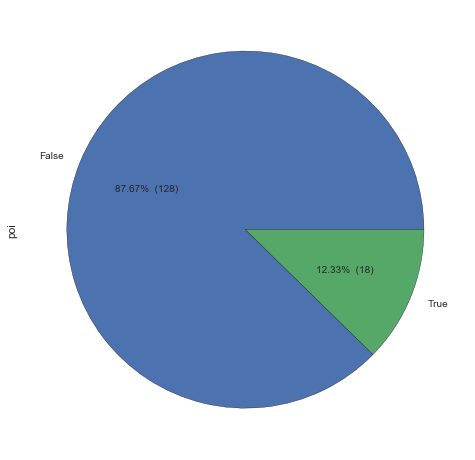

In [4]:
poiVsNotPoi = df.groupby('poi')['poi'].count()

poiVsNotPoi.plot.pie(figsize=(8, 8),
                    autopct = make_autopct(poiVsNotPoi))

### Number of features used

In [5]:
print "feature and data types"
print df.dtypes

print "\nNumber of features (poi is not a feature): " + str(len(list(df.columns.values)) - 1) 

feature and data types
salary                       float64
to_messages                  float64
deferral_payments            float64
total_payments               float64
exercised_stock_options      float64
bonus                        float64
restricted_stock             float64
shared_receipt_with_poi      float64
restricted_stock_deferred    float64
total_stock_value            float64
expenses                     float64
loan_advances                float64
from_messages                float64
other                        float64
from_this_person_to_poi      float64
poi                             bool
director_fees                float64
deferred_income              float64
long_term_incentive          float64
email_address                 object
from_poi_to_this_person      float64
dtype: object

Number of features (poi is not a feature): 20


### Are there features with many missing values? etc.

In [6]:
print "Missing values"
print df.isnull().sum()

Missing values
salary                        51
to_messages                   60
deferral_payments            107
total_payments                21
exercised_stock_options       44
bonus                         64
restricted_stock              36
shared_receipt_with_poi       60
restricted_stock_deferred    128
total_stock_value             20
expenses                      51
loan_advances                142
from_messages                 60
other                         53
from_this_person_to_poi       60
poi                            0
director_fees                129
deferred_income               97
long_term_incentive           80
email_address                  0
from_poi_to_this_person       60
dtype: int64


## Missing features, poi vs non poi

Maybe poi's are more likely to have some features

In [7]:
poiIsNull = df[df['poi'] == True].isnull().sum()

poiPctNull = poiIsNull / len(df[df['poi'] == True])

notPoiIsNull = df[df['poi'] != True].isnull().sum()

notPoiPctNull = notPoiIsNull / len(df[df['poi'] != True])
print pd.concat([poiIsNull,poiPctNull,notPoiIsNull,notPoiPctNull,poiPctNull-notPoiPctNull], axis=1)

                            0         1    2         3         4
salary                      1  0.055556   50  0.390625 -0.335069
to_messages                 4  0.222222   56  0.437500 -0.215278
deferral_payments          13  0.722222   94  0.734375 -0.012153
total_payments              0  0.000000   21  0.164062 -0.164062
exercised_stock_options     6  0.333333   38  0.296875  0.036458
bonus                       2  0.111111   62  0.484375 -0.373264
restricted_stock            1  0.055556   35  0.273438 -0.217882
shared_receipt_with_poi     4  0.222222   56  0.437500 -0.215278
restricted_stock_deferred  18  1.000000  110  0.859375  0.140625
total_stock_value           0  0.000000   20  0.156250 -0.156250
expenses                    0  0.000000   51  0.398438 -0.398438
loan_advances              17  0.944444  125  0.976562 -0.032118
from_messages               4  0.222222   56  0.437500 -0.215278
other                       0  0.000000   53  0.414062 -0.414062
from_this_person_to_poi  

There is a lot of data missing....

Although it looks like there are some trends here (for example):

- Every poi is missing restricted_stock_deferred.
- 5% of POIs are missing salary, but 40% of non pois are missing salary
- No POI is missing 'other' but 41% of non pois are missing

Trends like this make me think that for the financial data I should make some counters (for and against being a a poi)

## Features

For testing features I will run tests with the 3 classifiers... I want to test adding/changing features indpedent of the classifiers.

I am going to use email data: 

to_messages
from_messages
shared_receipt_with_poi
from_this_person_to_poi
from_poi_to_this_person

And use the financial as counters:

poi for things that when the there is a not null value is more likely a poi.
non_poi for things that when the there is a not null value is more likely not a poi.

salary (poi)

bonus (poi)

restricted_stock (poi)

restricted_stock_deferred (non_poi)

expenses (poi)

other (poi)

director_fees (non_poi)

deferred_income (poi)

long_term_incentive (poi)

### Outliers

In [8]:
email_data = ['to_messages',
              'from_messages',
              'from_poi_to_this_person',
              'from_this_person_to_poi',
              'shared_receipt_with_poi']

print "Distributions\n------------------"
for field in email_data:
    print df[field].describe()
    sortedDF = df.sort(field, ascending=0)
    print sortedDF[field].head()
    print "\n"

Distributions
------------------
count       86.000000
mean      2073.860465
std       2582.700981
min         57.000000
25%        541.250000
50%       1211.000000
75%       2634.750000
max      15149.000000
Name: to_messages, dtype: float64
SHAPIRO RICHARD S    15149.0
KEAN STEVEN J        12754.0
KITCHEN LOUISE        8305.0
BELDEN TIMOTHY N      7991.0
BECK SALLY W          7315.0
Name: to_messages, dtype: float64


count       86.000000
mean       608.790698
std       1841.033949
min         12.000000
25%         22.750000
50%         41.000000
75%        145.500000
max      14368.000000
Name: from_messages, dtype: float64
KAMINSKI WINCENTY J    14368.0
KEAN STEVEN J           6759.0
BECK SALLY W            4343.0
DELAINEY DAVID W        3069.0
MCCONNELL MICHAEL S     2742.0
Name: from_messages, dtype: float64


count     86.000000
mean      64.895349
std       86.979244
min        0.000000
25%       10.000000
50%       35.000000
75%       72.250000
max      528.000000
Name: from_

C:\Users\nicka\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


For these, there appearsto be any real standout outliers.

There is a row called 'TOTAL' and a row called 'THE TRAVEL AGENCY IN THE PARK' which should be removed.

In [9]:
df = df.drop('TOTAL')
df = df.drop('THE TRAVEL AGENCY IN THE PARK')

### Missing Values

For the following I need to figure out what to do with null values. 0 or mean?

to_messages
from_messages
shared_receipt_with_poi
from_this_person_to_poi
from_poi_to_this_person

My thought is to_messages and from_messages should recieve the mean (everyone sends emails) while the poi emails with null get a 0.

In [10]:
email_data = ['to_messages',
              'from_messages',
              'from_poi_to_this_person',
              'from_this_person_to_poi',
              'shared_receipt_with_poi']

#Fill all NAs with 0s
df_all_zero = df.copy()
df_all_zero[email_data] = df_all_zero[email_data].fillna(0)

#Fill all NAs with the mean of the column
df_all_mean = df.copy()
df_all_mean[email_data] = df_all_zero[email_data].fillna(df[email_data].mean())

#Fill some NAs with mean, and other with 9
df_mixed = df.copy()
df_mixed[email_data[:2]] = df_mixed[email_data[:2]].fillna(df[email_data[:2]].mean())
df_mixed[email_data[2:]] = df_mixed[email_data[2:]].fillna(0)

features = [('poi')] + email_data

import ml_test

#Import the classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

gnb = GaussianNB()
dt = tree.DecisionTreeClassifier()
svc = svm.SVC()
ada = AdaBoostClassifier(n_estimators=100)
rf = RandomForestClassifier(n_estimators=100)

clfs = [gnb,dt,svc,ada,rf]

#Test each data set with the classifiers
print "All zero:"
ml_test.testMany(df_all_zero,features,clfs,0.3)

print "All mean:"
ml_test.testMany(df_all_mean,features,clfs,0.3)

print "Mixed:"
ml_test.testMany(df_mixed,features,clfs,0.3)

All zero:
Classifier 1 - Acc: 0.666667 Precision: 0.019231. Recall: 0.083333
Classifier 2 - Acc: 0.840278 Precision: 0.171429. Recall: 0.341667
Classifier 3 - Acc: 0.875000 Precision: 0.000000. Recall: 0.000000


C:\Users\nicka\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Classifier 4 - Acc: 0.840278 Precision: 0.225000. Recall: 0.291667
Classifier 5 - Acc: 0.868056 Precision: 0.000000. Recall: 0.062500
All mean:
Classifier 1 - Acc: 0.666667 Precision: 0.019231. Recall: 0.083333
Classifier 2 - Acc: 0.819444 Precision: 0.162500. Recall: 0.291667
Classifier 3 - Acc: 0.875000 Precision: 0.000000. Recall: 0.000000
Classifier 4 - Acc: 0.840278 Precision: 0.225000. Recall: 0.291667
Classifier 5 - Acc: 0.868056 Precision: 0.000000. Recall: 0.000000
Mixed:
Classifier 1 - Acc: 0.652778 Precision: 0.009615. Recall: 0.041667
Classifier 2 - Acc: 0.840278 Precision: 0.283333. Recall: 0.391667
Classifier 3 - Acc: 0.875000 Precision: 0.000000. Recall: 0.000000
Classifier 4 - Acc: 0.805556 Precision: 0.000000. Recall: 0.000000
Classifier 5 - Acc: 0.868056 Precision: 0.000000. Recall: 0.000000


- Clearly SVM is just guessing false for everyone. That is why it's accuracy is high but it's recall is 0.

- Using 0's gives the best recall in nb and dt, so lets go with that.

In [11]:
df = df_all_zero

### Feature Testing

Test out how adding and removing  features makes a difference.

In [12]:
gnb = GaussianNB()
dt = tree.DecisionTreeClassifier()
svc = svm.SVC()
ada = AdaBoostClassifier(n_estimators=10)
rf = RandomForestClassifier(n_estimators=10)

clfs = [gnb,dt,svc,ada,rf]

#Test each data set with some features removed
print "to_messages:"
ml_test.testMany(df,features[:1] + features[2:],clfs,0.3)

print "from_messages:"
ml_test.testMany(df,features[:2] + features[3:],clfs,0.3)

print "from_poi_to_this_person:"
ml_test.testMany(df,features[:3] + features[4:],clfs,0.3)

print "from_this_person_to_poi:"
ml_test.testMany(df,features[:4] + features[5:],clfs,0.3)

print "shared_receipt_with_poi:"
ml_test.testMany(df[features[:5]],features[:5],clfs,0.3)

to_messages:
Classifier 1 - Acc: 0.666667 Precision: 0.019231. Recall: 0.083333
Classifier 2 - Acc: 0.840278 Precision: 0.350000. Recall: 0.250000
Classifier 3 - Acc: 0.875000 Precision: 0.000000. Recall: 0.000000
Classifier 4 - Acc: 0.833333 Precision: 0.216667. Recall: 0.175000
Classifier 5 - Acc: 0.847222 Precision: 0.500000. Recall: 0.145833
from_messages:
Classifier 1 - Acc: 0.784722 Precision: 0.035714. Recall: 0.041667
Classifier 2 - Acc: 0.847222 Precision: 0.145833. Recall: 0.208333
Classifier 3 - Acc: 0.875000 Precision: 0.000000. Recall: 0.000000
Classifier 4 - Acc: 0.833333 Precision: 0.083333. Recall: 0.062500
Classifier 5 - Acc: 0.868056 Precision: 0.125000. Recall: 0.125000
from_poi_to_this_person:
Classifier 1 - Acc: 0.666667 Precision: 0.026786. Recall: 0.125000
Classifier 2 - Acc: 0.854167 Precision: 0.154762. Recall: 0.208333
Classifier 3 - Acc: 0.875000 Precision: 0.000000. Recall: 0.000000
Classifier 4 - Acc: 0.840278 Precision: 0.125000. Recall: 0.062500
Classifie

- The recall gets worse when any feature is removed, so for now keep all the features (or maybe combine them...)

## Adding Features


### Finance Fields Count


Count the number of none-null values each person has for financal data fields.

In [13]:
finance_fields = ['salary',
                 'bonus',
                 'restricted_stock',
                 'expenses',
                 'other',
                 'deferred_income',
                 'long_term_incentive']

df['finance_field_count'] = df[finance_fields].notnull().sum(axis=1)

features_added_pos = features + ['finance_field_count']

print "Current features"
ml_test.testMany(df[features],features,clfs,0.3)

print "Added positive feature"
ml_test.testMany(df[features_added_pos],features_added_pos,clfs,0.3)

Current features
Classifier 1 - Acc: 0.666667 Precision: 0.019231. Recall: 0.083333
Classifier 2 - Acc: 0.826389 Precision: 0.208333. Recall: 0.341667
Classifier 3 - Acc: 0.875000 Precision: 0.000000. Recall: 0.000000
Classifier 4 - Acc: 0.840278 Precision: 0.083333. Recall: 0.050000
Classifier 5 - Acc: 0.875000 Precision: 0.062500. Recall: 0.062500
Added positive feature
Classifier 1 - Acc: 0.715278 Precision: 0.130482. Recall: 0.216667
Classifier 2 - Acc: 0.826389 Precision: 0.291667. Recall: 0.312500
Classifier 3 - Acc: 0.875000 Precision: 0.000000. Recall: 0.000000
Classifier 4 - Acc: 0.840278 Precision: 0.291667. Recall: 0.229167
Classifier 5 - Acc: 0.888889 Precision: 0.250000. Recall: 0.083333


The classifier works better when adding the finance fields count

### POI Email Rates

Make rates out of the to and from counters and the to and from poi counters.

In [14]:
df.ix[df.to_messages==0, 'to_rate'] = 0
df.ix[df.to_messages!=0, 'to_rate'] = df[df.to_messages!=0]['from_poi_to_this_person'] / df[df.to_messages!=0]['to_messages']

df.ix[df.from_messages==0, 'from_rate'] = 0
df.ix[df.from_messages!=0, 'from_rate'] = df[df.from_messages!=0]['from_this_person_to_poi'] / df[df.from_messages!=0]['from_messages']

rateFeatures = ['poi',
                'to_rate',
              'from_rate',
              'shared_receipt_with_poi',
               'finance_field_count']

print "Current features"
ml_test.testMany(df[features],features,clfs,0.3)

print "Rate features"
ml_test.testMany(df[rateFeatures],rateFeatures,clfs,0.3)

Current features
Classifier 1 - Acc: 0.666667 Precision: 0.019231. Recall: 0.083333
Classifier 2 - Acc: 0.819444 Precision: 0.162500. Recall: 0.291667
Classifier 3 - Acc: 0.875000 Precision: 0.000000. Recall: 0.000000
Classifier 4 - Acc: 0.840278 Precision: 0.083333. Recall: 0.050000
Classifier 5 - Acc: 0.847222 Precision: 0.000000. Recall: 0.000000
Rate features
Classifier 1 - Acc: 0.819444 Precision: 0.467262. Recall: 0.433333
Classifier 2 - Acc: 0.881944 Precision: 0.500000. Recall: 0.395833
Classifier 3 - Acc: 0.875000 Precision: 0.000000. Recall: 0.000000
Classifier 4 - Acc: 0.881944 Precision: 0.600000. Recall: 0.250000
Classifier 5 - Acc: 0.888889 Precision: 0.791667. Recall: 0.175000


Adding the rate fields seems to make a difference, so I will keep it.

### Feature Conclusion

For now I will keep all the email data and add the positive feature. These can be tunned!

In [15]:
feature_list = rateFeatures

## Classifier

Working with the modified set of features, naive bayes, decision tree and random forest stand out.

Even though nb seems to perform slightly better then random forrest, random forrest allows for more 'tuneabilty' so I will stick with it.

In [28]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold

labelIndex = feature_list[0]
featureIndexes = feature_list[1:]

labels = df[labelIndex].values[:].astype(bool)
features = df[featureIndexes].values[:,:].astype(np.float64)

clf = RandomForestClassifier(n_estimators=10)

from sklearn.cross_validation import StratifiedShuffleSplit
kf = StratifiedShuffleSplit(labels, 100, random_state = 42)

recallScore = cross_val_score(clf, features, labels, scoring='recall',cv=kf).mean()
perScore = cross_val_score(clf, features, labels, scoring='precision',cv=kf).mean()
accuracyScore = cross_val_score(clf, features, labels, scoring='accuracy',cv=kf).mean()

print "Acc: %f, Precision: %f, Recall: %f" % (accuracyScore,perScore,recallScore)

Acc: 0.863333, Precision: 0.296667, Recall: 0.245000


First, I will autoscale the inputs. See if that helps.

In [24]:
from sklearn import preprocessing

labelIndex = feature_list[0]
featureIndexes = feature_list[1:]

labels = df[labelIndex].values[:].astype(bool)
features = df[featureIndexes].values[:,:].astype(np.float64)

featuresScaled = preprocessing.scale(features)

clf = RandomForestClassifier(n_estimators=10)

recallScore = cross_val_score(clf, featuresScaled, labels, scoring='recall',cv=kf).mean()
perScore = cross_val_score(clf, featuresScaled, labels, scoring='precision',cv=kf).mean()
accuracyScore = cross_val_score(clf, featuresScaled, labels, scoring='accuracy',cv=kf).mean()

print "Acc: %f, Precision: %f, Recall: %f" % (accuracyScore,perScore,recallScore)

Acc: 0.865533, Precision: 0.309717, Recall: 0.225000


Scaling seems to help overall

Keep for now (can't hurt)

### Feature reduction (PCA)

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=len(featuresScaled[0])-1)

pcaFeatures = pca.fit_transform(featuresScaled)

clf = RandomForestClassifier(n_estimators=10)

recallScore = cross_val_score(clf, featuresScaled, labels, scoring='recall',cv=kf).mean()
perScore = cross_val_score(clf, featuresScaled, labels, scoring='precision',cv=kf).mean()
accuracyScore = cross_val_score(clf, featuresScaled, labels, scoring='accuracy',cv=kf).mean()

print "Acc: %f, Precision: %f, Recall: %f" % (accuracyScore,perScore,recallScore)


Acc: 0.865400, Precision: 0.316000, Recall: 0.219000


PCA seemed a little inconsistent. At best it does as good. At worst it does much worse. Don't use in final script.

By adding rates for poi emails, I manually reduced the dimensions.

### Feature Tunning

Tune for recall and precision (This take a while to run.... so watch out!)

In [29]:
from sklearn.grid_search import GridSearchCV

param_grid = {'max_depth': np.arange(2, 10),
             'min_samples_split': np.arange(5, 20),
             'class_weight': [None,'balanced'],
             'max_features': [None,'auto','sqrt']}

clf = GridSearchCV(RandomForestClassifier(n_estimators=5), param_grid,scoring='recall',n_jobs=-1,cv=kf)

clf.fit(featuresScaled,labels)

print "Best score: " + str(clf.best_score_)
print(clf.best_params_)
print(featureIndexes)
print(clf.best_estimator_.feature_importances_)

Best score: 0.67
{'max_features': 'auto', 'min_samples_split': 7, 'max_depth': 2, 'class_weight': 'balanced'}
['to_rate', 'from_rate', 'shared_receipt_with_poi', 'finance_field_count']
[ 0.17308955  0.36218729  0.05785878  0.40686438]


In [31]:
from sklearn.grid_search import GridSearchCV

param_grid = {'max_depth': np.arange(2, 10),
             'min_samples_split': np.arange(5, 20),
             'class_weight': [None,'balanced','balanced'],
             'max_features': [None,'auto','sqrt']}

clf = GridSearchCV(RandomForestClassifier(n_estimators=5), param_grid,scoring='precision',n_jobs=-1,cv=kf)

clf.fit(featuresScaled,labels)

print "Best score: " + str(clf.best_score_)
print(clf.best_params_)
print(featureIndexes)
print(clf.best_estimator_.feature_importances_)

Best score: 0.541357142857
{'max_features': None, 'min_samples_split': 15, 'max_depth': 2, 'class_weight': 'balanced'}
['to_rate', 'from_rate', 'shared_receipt_with_poi', 'finance_field_count']
[ 0.          0.49921876  0.25427025  0.24651099]


I want to optimize for max recall. I find that the values tuning for recall also give the best outcome for precision.